Based on https://github.com/deworrall92/interpretable_transformations

In [1]:
import os
import sys
import time

import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from matplotlib import pyplot as plt
from scipy.ndimage.interpolation import rotate
from torchvision import datasets, transforms
from scipy.optimize import curve_fit, least_squares, minimize

In [2]:
#arguments
batch_size = 64
test_batch_size = 64

epochs = 100
learning_rate = 0.001
momentum = 0.9 # 'SGD momentum'
latent_space=16

In [3]:
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


In [4]:
torch.manual_seed(1)
device = torch.device("cuda" if use_cuda else "cpu")

In [5]:
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=img_transform),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
                   transform=img_transform),
    batch_size=test_batch_size, shuffle=True, **kwargs)

In [6]:
class Net(nn.Module):
    def __init__(self, height, width, device):
        super(Net, self).__init__()

        self.height = height
        self.width = width
        self.device = device

        # Init model layers
        self.down1 = nn.Linear(self.height*self.width, 600)
        self.down2 = nn.Linear(600, 400)
        self.down3 = nn.Linear(400, latent_space)
        self.up3 = nn.Linear(latent_space, 400)
        self.up2 = nn.Linear(400, 600)
        self.up1 = nn.Linear(600, self.height*self.width)

    def encode(self, x, params):
        x = F.relu(self.down1(x))
        x = F.relu(self.down2(x))
        x = self.down3(x)   # Must be linear layer!
        x = self.feature_transformer(x, params)
        return x
    
    def decode(self, x):
        x = F.relu(self.up3(x))
        x = F.relu(self.up2(x))
        return torch.sigmoid(self.up1(x))
    
    def forward(self, x, params):
        x = self.encode(x, params)
        return self.decode(x)

    def feature_transformer(self, input, params):
        """For now we assume the params are just a single rotation angle

        Args:
            input: [N,c] tensor, where c = 2*int
            params: [N,1] tensor, with values in [0,2*pi)
        Returns:
            [N,c] tensor
        """
        # First reshape activations into [N,c/2,2,1] matrices
        x = input.view(input.size(0),input.size(1)//2,2,1)
        # Construct the transformation matrix
        sin = torch.sin(params)
        cos = torch.cos(params)
        transform = torch.cat([sin, -cos, cos, sin], 1)
        transform = transform.view(transform.size(0),1,2,2).to(self.device)
        # Multiply: broadcasting taken care of automatically
        # [N,1,2,2] @ [N,channels/2,2,1]
        output = torch.matmul(transform, x)
        # Reshape and return
        return output.view(input.size())


In [7]:
model = Net(28,28, device).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
def rotate_tensor(input):
    """Nasty hack to rotate images in a minibatch, this should be parallelized
    and set in PyTorch

    Args:
        input: [N,c,h,w] **numpy** tensor
    Returns:
        rotated output and angles in radians
    """
    angles = 2*np.pi*np.random.rand(input.shape[0])
    angles = angles.astype(np.float32)
    outputs = []
    for i in range(input.shape[0]):
        output = rotate(input[i,...], 180*angles[i]/np.pi, axes=(1,2), reshape=False)
        outputs.append(output)
    return np.stack(outputs, 0), angles

In [9]:
def train(model, device, train_loader, optimizer, epoch, log_interval=10):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Reshape data
        targets, angles = rotate_tensor(data.numpy())
        targets = torch.from_numpy(targets).to(device)
        targets = targets.view(targets.size(0), -1)
        angles = torch.from_numpy(angles).to(device)
        angles = angles.view(angles.size(0), 1)
        data = data.view(data.size(0), -1)

        # Forward pass
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data, angles)

        # Binary cross entropy loss
        loss_fnc = nn.BCELoss(reduction='sum')
        loss = loss_fnc(output, targets)

        # Backprop
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            sys.stdout.write('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\r'
                .format(epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            sys.stdout.flush()

In [10]:
def test(model, device, test_loader, epoch, test_batch_size):
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            # Reshape data: apply multiple angles to the same minibatch, hence
            # repeat
            data = data.view(data.size(0), -1)
            data = data.repeat(args.test_batch_size,1)

            angles = torch.linspace(0, 2*np.pi, steps=args.test_batch_size)
            angles = angles.view(args.test_batch_size, 1)
            angles = angles.repeat(1, args.test_batch_size)
            angles = angles.view(args.test_batch_size**2, 1)

            # Forward pass
            data = data.to(device)
            output = model(data, angles)
            break
        output = output.cpu()
        output = output.view(-1,1,28,28)
        save_images(output, epoch)

In [11]:
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    sys.stdout.write('\n')

Train Epoch: 1 [59520/60000 (99%)]	Loss: 6275.8183590
Train Epoch: 2 [59520/60000 (99%)]	Loss: 5765.940430
Train Epoch: 3 [59520/60000 (99%)]	Loss: 5758.365234
Train Epoch: 4 [59520/60000 (99%)]	Loss: 5831.030273
Train Epoch: 5 [59520/60000 (99%)]	Loss: 5402.896973
Train Epoch: 6 [59520/60000 (99%)]	Loss: 5742.275879
Train Epoch: 7 [59520/60000 (99%)]	Loss: 5293.776855
Train Epoch: 8 [59520/60000 (99%)]	Loss: 5140.505371
Train Epoch: 9 [59520/60000 (99%)]	Loss: 4873.702637
Train Epoch: 10 [59520/60000 (99%)]	Loss: 5080.595215
Train Epoch: 11 [59520/60000 (99%)]	Loss: 4922.449219
Train Epoch: 12 [59520/60000 (99%)]	Loss: 5152.587891
Train Epoch: 13 [59520/60000 (99%)]	Loss: 4718.731445
Train Epoch: 14 [59520/60000 (99%)]	Loss: 4946.002441
Train Epoch: 15 [59520/60000 (99%)]	Loss: 4933.118652
Train Epoch: 16 [59520/60000 (99%)]	Loss: 5118.564453
Train Epoch: 17 [59520/60000 (99%)]	Loss: 4927.437012
Train Epoch: 18 [59520/60000 (99%)]	Loss: 4921.715332
Train Epoch: 19 [59520/60000 (99%)]	

In [12]:
l = next(iter(test_loader))

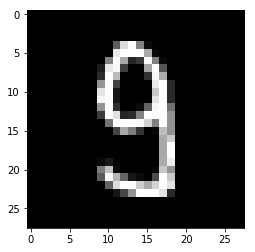

In [13]:
l00 = l[0][:1,:,:]
plt.imshow(l00.numpy()[0, 0,:,:], cmap='gray')

In [14]:
n_rot = 10
with torch.no_grad():
    angles = torch.linspace(0, 2*np.pi, steps=n_rot)
    angles = angles.view(n_rot, 1)

    data = l00[0]
    data = data.view(data.size(0), -1)
    data = data.repeat(n_rot, 1)
    data = data.to(device)

    output = model(data, angles)
    output = output.cpu()
    output = output.view(-1,1,28,28)

In [15]:
output.numpy().shape

(10, 1, 28, 28)

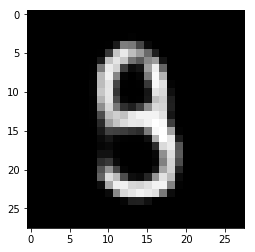

In [16]:
plt.imshow(output.numpy()[0,0], cmap='gray')

In [17]:
n_rot = 32
with torch.no_grad():
    angles = torch.linspace(0, 2*np.pi, steps=n_rot)
    angles = angles.view(n_rot, 1)

    data = l00[0]
    data = data.view(data.size(0), -1)
    data = data.repeat(n_rot, 1)
    data = data.to(device)

    output = model.encode(data, angles)
    output = output.cpu()
#     output = output.view(-1,1,28,28)

In [18]:
o_np = output.numpy()

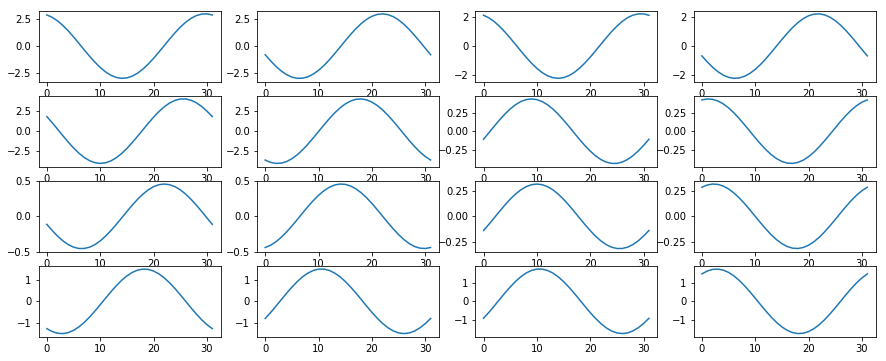

In [26]:
f, ax = plt.subplots(4, 4, figsize=(15, 6))
for i in range(4): 
    for j in range(4):
        ax[i][j].plot(o_np[:,i*4 + j])

Each output seems to come from a $\sin$ function

In [20]:
with torch.no_grad():
    dec = model.decode(output.to(device))
    dec = dec.cpu().view(-1,1,28,28)

In [21]:
d_np = dec.numpy()

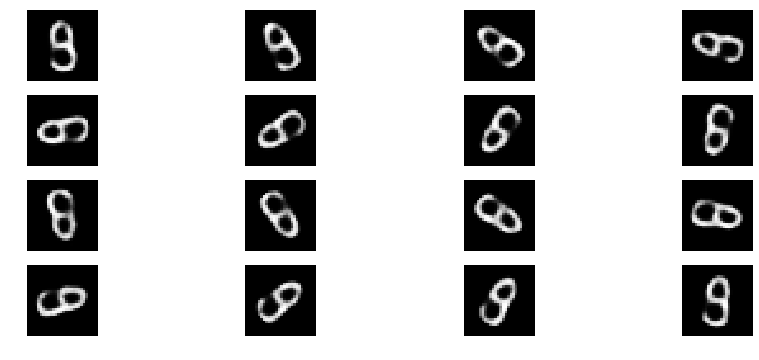

In [25]:
f, ax = plt.subplots(4, 4, figsize=(15, 6))
for i in range(4): 
    for j in range(4):
        ax[i][j].imshow(d_np[2*(i*4 + j),0], cmap='gray')
        ax[i][j].axis('off')

In [23]:
torch.save(model.state_dict(), 'mnist_linear_model')

In [24]:
l_model = Net(28,28, device).to(device)
l_model.load_state_dict(torch.load('mnist_linear_model'))
l_model.eval()

Net(
  (down1): Linear(in_features=784, out_features=600, bias=True)
  (down2): Linear(in_features=600, out_features=400, bias=True)
  (down3): Linear(in_features=400, out_features=16, bias=True)
  (up3): Linear(in_features=16, out_features=400, bias=True)
  (up2): Linear(in_features=400, out_features=600, bias=True)
  (up1): Linear(in_features=600, out_features=784, bias=True)
)